# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [28]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [29]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [30]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [31]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [32]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [33]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [34]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [35]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [36]:
import collections
import io
import logging
import sys
import time

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [165]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)
total_terms = 0
document_freqs = {}

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

# print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.


In [192]:
def run_retrieval(model_name, score_fn, params):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    :param params: params needed for chosen model
    """
    if model_name == 'JM' or model_name == 'DP' or model_name == 'AD':
        params_string = '-'.join(map(str, params))
        run_out_path = '{0}-{1}.run'.format(model_name, params_string)
    else:
        run_out_path = '{}.run'.format(model_name)    
        
    # Don't run twice
    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = {}
    for query_id in queries:
        doc_ids = top1000_query_docs[query_id]
        
        scores = []
        for doc_id in doc_ids:
            ext_doc_id, _ = index.document(doc_id)
            score = 0
            if model_name == 'tfidf':
                for query_token in tokenized_queries[query_id]:
                    score += score_fn(doc_id, query_token, inverted_index, num_documents)
            elif model_name == 'BM25':
                k1 = params[0]
                b = params[1]
                score = score_fn(doc_id, tokenized_queries[query_id], inverted_index, document_lengths, k1, b)
            elif model_name == 'JM' or model_name == 'DP' or model_name == 'AD':
                param = params[0]  
                query_tokens = tokenized_queries[query_id]
                lm = score_fn(doc_id, query_tokens, inverted_index, collection_frequencies, unique_terms_per_document, model_name, param)
                # Calculate P(q|d)
                P_q_d = 1
                for query_token in query_tokens:
                    P_q_d *= lm[query_token]
                score = P_q_d
            elif model_name == 'PLM':
                sigma = params[0]
                mu = params[1]
                query_tokens = tokenized_queries[query_id]
                score = score_fn(doc_id, query_tokens, inverted_index, collection_frequencies, index, sigma, mu)
            scores.append((score, ext_doc_id))
        data[query_id] = scores
    
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
        
# Any parameters needed for the corresponding score function in the order in which the function takes them as argument
print(len(queries))
plm_params = [50, 500]
bm25_params = [1.2, 0.75]
jm_params = [0.5]
ad_params = [0.9]
dp_params = [1500]
print(len(document_lengths))
run_retrieval('DP', makeLM, dp_params)


150
164597
Retrieving using DP


In [ ]:
ext_to_doc_id = {}
# Dictionary for the external doc id to integer doc id
for i in range(1,num_documents+1):
    ext_to_doc_id[index.document(i)[0]] = i
    
# Returns the top 1000 of the tfidf scores of a query id
def run_retrieval_top1000(query_id, ext_to_doc_id):
    with open('tfidf.run', 'r') as f_out:
        scores = f_out.readlines() 
    for i in range(0, len(scores), 1000):
        score = scores[i].split()
        if score[0] == query_id:
            index_query = i
            break
    top1000_doc_ids = []
    for i in range(index_query, index_query+1000):
        ext_doc_id = scores[i].split()[2]
        top1000_doc_ids.append(ext_to_doc_id[ext_doc_id])
    return top1000_doc_ids
top1000_doc_ids = run_retrieval_top1000('51', ext_to_doc_id)


In [178]:
# Dictionary for the top 1000 doc ids with highest tfidf scores per query {query_id : [Top1000]}
top1000_query_docs = {}
for query_id in queries:
    top1000_query_docs[query_id] = run_retrieval_top1000(query_id, ext_to_doc_id)

In [38]:
import numpy as np

# Evaluate the Language models with the use of the TREC evaluations methods
def evaluate(run_file, qrel_file):
    qrel_location = "ap_88_89/" + qrel_file
    
    map_1000 = !trec_eval/trec_eval -m all_trec -q {qrel_location} {run_file} | grep "map_cut_1000"  
    ndcg_10 = !trec_eval/trec_eval -m all_trec -q {qrel_location} {run_file} | grep "ndcg_cut_10"
    precision_5 = !trec_eval/trec_eval -m all_trec -q {qrel_location} {run_file} | grep "P_5"  
    recall_1000 = !trec_eval/trec_eval -m all_trec -q {qrel_location} {run_file} | grep "recall_1000"  
    # Retrieve id and score from trec_eval output
    map_1000 = [(score.split()[1], score.split()[2]) for score in np.array(map_1000)]
    ndcg_10 = [(score.split()[1], score.split()[2]) for score in np.array(ndcg_10)]
    precision_5 = [(score.split()[1], score.split()[2]) for score in np.array(precision_5)]
    recall_1000 = [(score.split()[1], score.split()[2]) for score in np.array(recall_1000)]

    return map_1000, ndcg_10, precision_5, recall_1000

# Compute all values for all different parameter values and different smoothing techniques
map_1000_AD_1, ndcg_10_AD_1, precision_5_AD_1, recall_1000_AD_1 = evaluate('AD-0.1.run', 'qrel_validation')
map_1000_AD_5, ndcg_10_AD_5, precision_5_AD_5, recall_1000_AD_5 = evaluate('AD-0.5.run', 'qrel_validation')
map_1000_AD_9, ndcg_10_AD_9, precision_5_AD_9, recall_1000_AD_9 = evaluate('AD-0.9.run', 'qrel_validation')

map_1000_JM_1, ndcg_10_JM_1, precision_5_JM_1, recall_1000_JM_1 = evaluate('JM-0.1.run', 'qrel_validation')
map_1000_JM_5, ndcg_10_JM_5, precision_5_JM_5, recall_1000_JM_5 = evaluate('JM-0.5.run', 'qrel_validation')
map_1000_JM_9, ndcg_10_JM_9, precision_5_JM_9, recall_1000_JM_9 = evaluate('JM-0.9.run', 'qrel_validation')

map_1000_DP_500, ndcg_10_DP_500, precision_5_DP_500, recall_1000_DP_500 = evaluate('DP-500.run', 'qrel_validation')
map_1000_DP_1000, ndcg_10_DP_1000, precision_5_DP_1000, recall_1000_DP_1000 = evaluate('DP-1000.run', 'qrel_validation')
map_1000_DP_1500, ndcg_10_DP_1500, precision_5_DP_1500, recall_1000_DP_1500 = evaluate('DP-1500.run', 'qrel_validation')

map_1000_tfidf, ndcg_10_tfidf, precision_5_tfidf, recall_1000_tfidf = evaluate('tfidf.run', 'qrel_validation')

map_1000_BM25, ndcg_10_BM25, precision_5_BM25, recall_1000_BM25 = evaluate('BM25.run', 'qrel_validation')

map_1000_AD_5_test, ndcg_10_AD_5_test, precision_5_AD_5_test, recall_1000_AD_5_test = evaluate('AD-0.5.run', 'qrel_test')
map_1000_JM_5_test, ndcg_10_JM_5_test, precision_5_JM_5_test, recall_1000_JM_5_test = evaluate('JM-0.5.run', 'qrel_test')
map_1000_DP_1000_test, ndcg_10_DP_1000_test, precision_5_DP_1000_test, recall_1000_DP_1000_test = evaluate('DP-1000.run', 'qrel_test')
map_1000_BM25_test, ndcg_10_BM25_test, precision_5_BM25_test, recall_1000_BM25_test = evaluate('BM25.run', 'qrel_test')
map_1000_tfidf_test, ndcg_10_tfidf_test, precision_5_tfidf_test, recall_1000_tfidf_test = evaluate('tfidf.run', 'qrel_test')

print("Test results AD:")
print(map_1000_AD_5_test[-1])
print(ndcg_10_AD_5_test[-1])
print(precision_5_AD_5_test[-1])
print(recall_1000_AD_5_test[-1])
print("")

print("Test results JM:")
print(map_1000_JM_5_test[-1])
print(ndcg_10_JM_5_test[-1])
print(precision_5_JM_5_test[-1])
print(recall_1000_JM_5_test[-1])
print("")

print("Test results DP:")
print(map_1000_DP_1000_test[-1])
print(ndcg_10_DP_1000_test[-1])
print(precision_5_DP_1000_test[-1])
print(recall_1000_DP_1000_test[-1])
print("")

print("Test results BM25:")
print(map_1000_BM25_test[-1])
print(ndcg_10_BM25_test[-1])
print(precision_5_BM25_test[-1])
print(recall_1000_BM25_test[-1])
print("")

print("Test results tfidf:")
print(map_1000_tfidf_test[-1])
print(ndcg_10_tfidf_test[-1])
print(precision_5_tfidf_test[-1])
print(recall_1000_tfidf_test[-1])
print("")

Test results AD:
('all', '0.1834')
('all', '0.4581')
('all', '0.5500')
('all', '0.6491')

Test results JM:
('all', '0.1736')
('all', '0.4488')
('all', '0.5169')
('all', '0.6491')

Test results DP:
('all', '0.1882')
('all', '0.4597')
('all', '0.5466')
('all', '0.6491')

Test results BM25:
('all', '0.2015')
('all', '0.4750')
('all', '0.5552')
('all', '0.6491')

Test results tfidf:
('all', '0.2200')
('all', '0.4920')
('all', '0.5641')
('all', '0.6491')



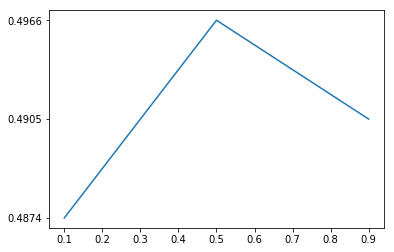

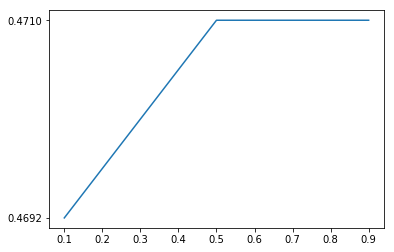

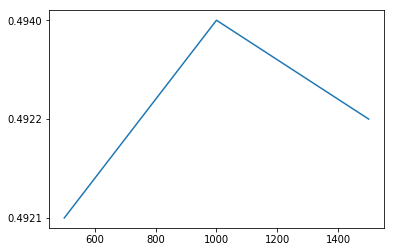

In [40]:
# Plot different ndcg values per parameter change to retrieve optimal parameter.
import matplotlib.pyplot as plt
plt.plot([0.1,0.5,0.9], [ndcg_10_AD_1[-1][1],ndcg_10_AD_5[-1][1],ndcg_10_AD_9[-1][1]])
plt.show()
plt.plot([0.1,0.5,0.9], [ndcg_10_JM_1[-1][1],ndcg_10_JM_5[-1][1],ndcg_10_JM_9[-1][1]])
plt.show()
plt.plot([500,1000,1500], [ndcg_10_DP_500[-1][1],ndcg_10_DP_1000[-1][1],ndcg_10_DP_1500[-1][1]])
plt.show()



In [42]:
import math

# Term frequency per document
def calculate_tf(document_id, query_term_id, inverted_index):
    try:
        document_term_frequency = inverted_index[query_term_id][document_id]
        log_tf = 1 + math.log(document_term_frequency)
        return log_tf
    except KeyError:
        return 0

# Compute tf-idf values
def tfidf(int_document_id, query_term_id, inverted_index, N):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    
    log_tf = calculate_tf(int_document_id, query_term_id, inverted_index)
    document_frequency = len(inverted_index[query_term_id])
    log_idf = math.log(N) - math.log(document_frequency)
    score = log_tf*log_idf
    return score

tfidf(2, 20, inverted_index, num_documents)
# combining the two functions above: 
# run_retrieval('tfidf', tfidf)
# TODO implement the rest of the retrieval functions 

# TODO implement tools to help you with the analysis of the results.

3.096249787983831

In [43]:
# Compute BM25 values
def BM25(document_id, query_ids, inverted_index, document_lengths, k1, b):
    N = len(document_lengths)
    unique_query_terms = set(query_ids)
    l_d = document_lengths[document_id]
    total_length = sum(document_lengths.values())
    l_avg = total_length/N
    BM25 = 0
    for query_term_id in unique_query_terms:
        try:
            log_tf = calculate_tf(document_id, query_term_id, inverted_index)
            document_frequency = len(inverted_index[query_term_id])
            log_idf = math.log(N) - math.log(document_frequency)
            BM25 += ((k1 + 1)*log_tf)/(k1*((1 - b) + b * (l_d/l_avg)) + log_tf) * log_idf
        except KeyError:
            BM25 += 0
    return BM25

BM25(99783, tokenized_queries['90'], inverted_index, document_lengths, 1.2, 0.75)

7.5346740771599805

In [44]:
# Jelinek-Mercer smoothing technique
def JM_smoothing(document_id, query_term_id, collection_frequencies, document_lengths, inverted_index, l):
    log_tf = calculate_tf(document_id, query_term_id, inverted_index)
    tf_C = collection_frequencies[query_term_id]
    log_tf_C = 1 + math.log(tf_C)
    doc_length = document_lengths[document_id]
    len_C = sum(document_lengths.values())
    P_JM = l*(log_tf/doc_length) + (1 - l)*(log_tf_C)/len_C
    return P_JM

l = 0.9
JM_smoothing(99783, 1275, collection_frequencies, document_lengths, inverted_index, l)

0.004776927520830531

In [45]:
# Dirichlet prior smoothing technique
def DP_smoothing(document_id, query_term_id, document_lengths, inverted_index, collection_frequencies, mu):
    log_tf = calculate_tf(document_id, query_term_id, inverted_index)
    doc_length = document_lengths[document_id]
    tf_C = collection_frequencies[query_term_id]
    P_w_C = tf_C/sum(collection_frequencies.values())
    P_DP = (doc_length/(doc_length + mu))*(log_tf/doc_length) + (mu/(mu + doc_length))*P_w_C
    return P_DP

mu = 500
DP_smoothing(99783, 1275, document_lengths, inverted_index, collection_frequencies, mu)

0.002994628735132055

In [46]:
# Absolute discounting smoothing technique
def AD_smoothing(document_id, query_term_id, document_lengths, inverted_index, collection_frequencies, unique_terms_per_document, delta):
    log_tf = calculate_tf(document_id, query_term_id, inverted_index)
    doc_length = document_lengths[document_id]
    d_u = unique_terms_per_document[document_id]
    tf_C = collection_frequencies[query_term_id]
    P_w_C = tf_C/sum(collection_frequencies.values())
    P_AD = max(log_tf - delta, 0)/doc_length + ((delta*d_u)/doc_length) * P_w_C
    return P_AD

delta = 0.1
AD_smoothing(99783, 1275, document_lengths, inverted_index, collection_frequencies, unique_terms_per_document, delta)

0.0051056100822080355

In [47]:
from collections import defaultdict

# Create a language model based on the smoothing technique used
def makeLM(document_id, query_ids, inverted_index, collection_frequencies, unique_terms_per_document, smoothing, param):
    doc_length = document_lengths[document_id]
    len_C = sum(document_lengths.values())
    prob_query = defaultdict(float)
    for query_id in query_ids:
        log_tf = calculate_tf(document_id, query_id, inverted_index)
        tf_C = collection_frequencies[query_id]
        log_tf_C = 1 + math.log(tf_C)
        P_w_C = tf_C/sum(collection_frequencies.values())
        if smoothing == "AD":
            d_u = unique_terms_per_document[document_id]
            P_w_C = tf_C/sum(collection_frequencies.values())
            prob_query[query_id] = max(log_tf - param, 0)/doc_length + ((param*d_u)/doc_length) * P_w_C
        elif smoothing == "DP":
            P_w_C = tf_C/sum(collection_frequencies.values())
            prob_query[query_id] = (doc_length/(doc_length + param))*(log_tf/doc_length) + (param/(param + doc_length))*P_w_C
        elif smoothing == "JM":
            prob_query[query_id] = param*(log_tf/doc_length) + (1 - param)*(log_tf_C)/len_C
    return prob_query

smoothing = "DP"
param = 0.1
doc_id = 99783
LM = makeLM(doc_id, query_term_ids, inverted_index, collection_frequencies, unique_terms_per_document, smoothing, param)


In [48]:
# Compute term frequency per position
def TFPP(document_id, word_id, inverted_index, tokens, sigma, j):
    tf_sum = 0
    Z_i = 0
    for i in range(len(tokens)):
        if tokens[i] == word_id:
            tf_i = 1
        else:
            tf_i = 0
        kernel = Gaussian(j, i, sigma)
        Z_i += kernel
        tf_sum += tf_i*kernel
    return tf_sum, Z_i

# Calculate Language model per position
def LMPP(document_id, word_id, inverted_index, collection_frequencies, index, sigma, j, mu):
    tokens = index.document(document_id)[1]
    tf_C = collection_frequencies[word_id]
    P_w_C = tf_C/sum(collection_frequencies.values())
    tf_w, Z_i = TFPP(document_id, word_id, inverted_index, tokens, sigma, j)    
    P_w_D = (tf_w + mu*P_w_C)/(Z_i + mu)
    return P_w_D

# 5 different kernel implementations
def Gaussian(i, j, sigma):
    return math.exp((-(i - j)**2)/(2*sigma**2))

def Triangle(i, j, sigma):
    if abs(i - j) <= sigma:
        return 1 - abs(i - j)/sigma
    else:
        return 0

def Cosine(i, j, sigma):
    if abs(i - j) <= sigma:
        return 0.5*(1 + math.cos((abs((i - j) * math.pi))/sigma))
    else:
        return 0

def Circle(i, j, sigma):
    if abs(i - j) <= sigma:
        return math.sqrt((1 - ((abs(i - j))/sigma)))
    else:
        return 0
    
def Passage(i, j, sigma):
    if abs(i - j) <= sigma:
        return 1
    else:
        return 0

mu = 500
j = 2
sigma = 50
doc_id = 99783
term_id = 1275
LMPP(doc_id, term_id, inverted_index, collection_frequencies, index, sigma, j, mu)

0.00200784812289836

In [49]:
# Retrieve the test and validation set
with open("ap_88_89/qrel_test") as f:
    test_set = f.readlines()
with open("ap_88_89/qrel_validation") as f:
    val_set = f.readlines()


In [50]:
from collections import Counter

# Computes the S(Q,D,j) of a query and a document
def PLM_score(document_id, query_ids, inverted_index, collection_frequencies, index, sigma, j, mu):
    score = 0
    query_counter = Counter(query_ids)
    unique_tokens = set(index.document(document_id)[1])
    unique_query_ids = set(query_ids)
    # Only calculate P_w_Q for words in query, for other words P_w_Q = 0
    for word_id in unique_query_ids:
        P_w_Q = query_counter[word_id]/len(query_ids)
        P_w_D = LMPP(document_id, word_id, inverted_index, collection_frequencies, index, sigma, j, mu)
        if P_w_D != 0:
            score += P_w_Q*math.log(P_w_Q/P_w_D)
    return -score

# Computes the best position strategy S(Q,D) of a document and a query 
def best_position_strategy(document_id, query_ids, inverted_index, collection_frequencies, index, sigma, mu):
    tokens = index.document(document_id)[1]
    highest_score = PLM_score(document_id, query_ids, inverted_index, collection_frequencies, index, sigma, 0, mu)
    for j in range(1, len(tokens)): 
        score = PLM_score(document_id, query_ids, inverted_index, collection_frequencies, index, sigma, j, mu)
        if score > highest_score:
            highest_score = score
    return highest_score

# print(index.document(doc_id)[1])
query = [5063, 151114, 4414, 4160, 78152]
best_position_strategy(doc_id, query, inverted_index, collection_frequencies, index, sigma, mu)

-4.723197087353424

### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [189]:
def cosine_similarity(vec1, vec2):
    return vec1.dot(vec2)

def kl_divergence(a, b):
    return np.sum(a * np.log(a)) - np.sum(a * np.log(b))

def top_1000(query_ids):
    document_ids = itertools.chain(*[list(inverted_index[i].keys()) for i in query_term_ids])
    scores = []
    for document_id in document_ids:
        total_score = 0
        
        for query_id in query_ids:
            total_score += tfidf(document_ids, query_id)
        scores.append((document_idid, total_score))
        
    scores.sort(key=lambda x: x[1], reverse=True)
    return [x[0] for x in scores][:1000]

In [190]:
# http://www.pythonexample.com/code/gensim-python-tutorial/ was used

import gensim

class Corpus(gensim.interfaces.CorpusABC):

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary

        self.max_documents = max_documents
    
    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())
    
    def _tokens2bow(self, tokens):
        tokens = [token_id for token_id in tokens if token_id > 0]
        token_dict = collections.defaultdict(int)
        
        for token_id in tokens:
            token_dict[token_id] += 1
            
        return [(key, value) for key, value in token_dict.items()]  
    
    def __iter__(self):
        for internal_document_id in range(self.index.document_base(), self.index.maximum_document()):
            external_document_id, token_ids = self.index.document(internal_document_id)
            
            yield self._tokens2bow(token_ids)
            
    def __len__(self):
        return self._maximum_document() - self.index.document_base()

In [191]:
from collections import defaultdict

num_topics = 10

corpus =  Corpus(index, dictionary)

data = defaultdict(list)

# Create document representations (LSM/LDA) which also resorts by these scores

lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics)
#lsi.save('LSI_models/LSI1') # Should just use the given function?

lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics)
#lda.save('LDA_models/LDA1')

for query_id, query_term_ids in tokenized_queries.items():
    document_bow = collections.Counter(token_id for token_id in query_term_ids)
    document_vector = []
    for token_id in query_term_ids:
        document_vector.append((token_id, document_bow[token_id]))
        
    # Get the sorted top 1000 rankings of documents using tf-idf scores
    
    documents = gensim.matutils.corpus2dense([lsi[corpus]], num_terms=num_topics)
    query = gensim.matutils.corpus2dense([lsi[document_vector]], num_terms=num_topics)
    indices = get_top_1000(query_term_ids)
    
    similarities = cosine_similarity(latent_query.T, docs)
    for internal_document_id in indices:
        external_document_id, document_token_ids = corpus.index.document(internal_document_id)
        score = similarities[0][internal_document_id]
        data[query_id].append((score, external_document_id))

with open(run_out_path, 'w') as f_out:
    write_run(
        model_name=model_name,
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)

ValueError: too many values to unpack (expected 2)

In [ ]:
import matplotlib.pyplot as plt

# Report on the measures NDCG@10, Mean Average Precision (MAP@1000), Precision@5 and Recall@1000 using trec_eval

file_name = ""
eval_method = '(ndcg_cut_10\W+all)'
qrel_set = 'ap_88_89/qrel_validation'
cmd = 'trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + eval_methods + '"'
ndcg_10 = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [102]:
import pyndri.compat
import copy

# Train the word 2 vec embedding based on the example given in the assignment
def train_word2vec(corpus):
    
    word2vec_init = gensim.models.Word2Vec(
    size=300,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)
    word2vec_init.build_vocab(corpus, trim_rule=None)

    models = [word2vec_init]
    model = copy.deepcopy(models[-1])
    model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)

    models.append(model)
    return models
    
# Retrieve corpus from pydnri
corpus = pyndri.compat.IndriSentences(index, dictionary)
models = train_word2vec(corpus)



In [171]:
# Represent text with the use of tf-idf weights
def text_representation(word2vec_model, tokens, N):
    tokens = tokens.split()
    token_counter = Counter(tokens)
    embedded_tokens = [word2vec_model.wv[token.lower()] for token in tokens]
    token_weights = []
    for i in range(len(tokens)):
        token_id = token2id[tokens[i]]
        document_frequency = len(inverted_index[token_id])
        # Compute the tf_idf weights per word in query
        log_idf = math.log(N) - math.log(document_frequency)
        term_frequency = token_counter[tokens[i]]
        log_tf = 1 + math.log(term_frequency)
        token_weights.append(log_tf*log_idf)
    # Average over them to compute query weight
    avg_token_weights = np.array(token_weights)/sum(token_weights)
    representation = []
    for i in range(len(tokens)):
        representation.append(embedded_tokens[i]*avg_token_weights[i])
    return sum(representation)
# text_representation(models[1], queries['161'].lower(), num_documents)


In [172]:
print(dictionary[122])

12


In [185]:
# Examples for the report results
query = 'acid'
query_vector_acid = text_representation(models[1], query, num_documents)
query = "rain"
query_vector_rain = text_representation(models[1], query, num_documents)
query = "acid rain"
query_vector_acid_rain = text_representation(models[1], query, num_documents)
query = "political"
query_vector = text_representation(models[1], query, num_documents)
query = "campaign"
query_vector_c = text_representation(models[1], query, num_documents)
query = "political campaign"
query_vector_p_c = text_representation(models[1], query, num_documents)


In [188]:
# Pretty print the vector similarities for the report
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(models[1].wv.similar_by_vector(query_vector_acid))
pp.pprint(models[1].wv.similar_by_vector(query_vector_rain))
pp.pprint(models[1].wv.similar_by_vector(query_vector_acid_rain))
pp.pprint(models[1].wv.similar_by_vector(query_vector))
pp.pprint(models[1].wv.similar_by_vector(query_vector_c))
pp.pprint(models[1].wv.similar_by_vector(query_vector_p_c))


[   ('political', 1.0000001192092896),
    ('politics', 0.6508501172065735),
    ('allegiances', 0.6247718334197998),
    ('repudiation', 0.6204284429550171),
    ('ideologically', 0.6204048991203308),
    ('resolutely', 0.6200169324874878),
    ('apolitical', 0.6140182614326477),
    ('politicans', 0.6131746172904968),
    ('espouses', 0.6130253076553345),
    ('ideologies', 0.6124864220619202)]
[   ('campaign', 1.0000003576278687),
    ('campaigns', 0.794968843460083),
    ('campaigning', 0.73048996925354),
    ('estrich', 0.6640328168869019),
    ('gores', 0.6527309417724609),
    ('sasso', 0.6496798396110535),
    ('gephardts', 0.6389736533164978),
    ('atwater', 0.6307360529899597),
    ('fundraising', 0.6277785897254944),
    ('dach', 0.6268733143806458)]
[   ('campaign', 0.8933532238006592),
    ('political', 0.8200625777244568),
    ('campaigns', 0.7580133080482483),
    ('mudslinging', 0.7025280594825745),
    ('campaigning', 0.6957234740257263),
    ('fundraising', 0.6890807

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [217]:
import numpy as np
import sklearn
import sklearn.linear_model

# Compute the different weight scores
def get_features(document_id, query):
    query_term_ids = set(
    query_term_id
    for query_term_id in query)
    tfidf_score = 0
    for query_term in query_term_ids:
        tfidf_score += tfidf(document_id, query_term_id, inverted_index, num_documents)
    bm25_score = BM25(document_id, query_term_ids, inverted_index, document_lengths, 1.2, 0.75)
    return np.asarray([tfidf_score, bm25_score])


def make_dataset(qrel_file):

    x = []
    y = []
    
    with open('ap_88_89/' + qrel_file, 'r') as f:
        for line in f:
            query_id, _, ext_document_id, actual_score = line.split(" ")
            
            if query_id in queries:
                query_tokens = index.tokenize(queries[query_id])
                query = [token2id.get(query_token,0) for query_token in query_tokens]
                query = [word_id for word_id in query if word_id > 0]
                
                if not index.document_ids([ext_document_id]):
                    continue
                document_id = index.document_ids([ext_document_id])[0][1]
                document = index.document(document_id)

                x.append(get_features(document_id, query))
                y.append(float(actual_score[0]))
        
    return (np.asarray(x), np.asarray(y))
    
data_points_used = 30000    
    
x, y = make_dataset('qrel_test')

logist_model = sklearn.linear_model.LogisticRegression()
logist_model.fit(x[:data_points_used], y[:data_points_used])
logist_model.score(x[data_points_used::], y[data_points_used::])

0.7013213151695176

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
